<a href="https://colab.research.google.com/github/Sirfowahid/FFN/blob/master/FNN_FNNonMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

labels = data[:,0]
data = data[:,1:]

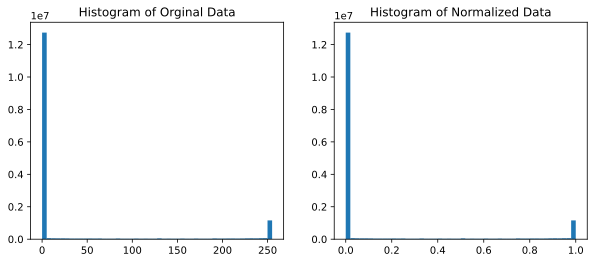

In [3]:
dataNorm = data / np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))

ax[0].hist(data.flatten(),50)
ax[0].set_title('Histogram of Orginal Data')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_title('Histogram of Normalized Data')

plt.show()

In [5]:
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

train_data,test_data,train_labels,test_labels = train_test_split(dataT,labelsT,test_size=.1)

train_dataset = TensorDataset(train_data,train_labels)
test_dataset = TensorDataset(test_data,test_labels)

batchsize = 32
train_loader = DataLoader(train_dataset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader = DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])

In [6]:
def createTheMNISTNet():

  class mnistNet(nn.Module):

    def __init__(self):
      super().__init__()

      self.input = nn.Linear(784,64)

      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      self.output = nn.Linear(32,10)

    def forward(self,x):
      x = F.relu(self.input(x))
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))

      return torch.log_softmax(self.output(x),axis = 1)

  net = mnistNet()

  lossfun = nn.NLLLoss()
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer



In [7]:
net,lossfun,optimizer = createTheMNISTNet()

X,y = iter(train_loader).next()
yHat = net(X)

loss = lossfun(yHat,y)

print(loss)

tensor(2.3334, grad_fn=<NllLossBackward0>)


In [10]:
def fun2trainTheModel():

   numepochs = 60

   net,lossfun,optimizer = createTheMNISTNet()

   losses = torch.zeros(numepochs)
   trainAcc = []
   testAcc = []

   for epochi in range(numepochs):

     batchAcc = []
     batchLoss = []

     for X,y in train_loader:

       yHat = net(X)

       loss = lossfun(yHat,y)

       optimizer.zero_grad()
       loss.backward()
       optimizer.step()

       batchLoss.append(loss.item())
       matches = torch.argmax(yHat,axis=1) == y
       matchesNumeric = matches.float()
       accPct = 100*torch.mean(matchesNumeric)
       batchAcc.append(accPct)
     
     trainAcc.append(np.mean(batchAcc))
     losses[epochi] = np.mean(batchLoss)

     X,y = next(iter(test_loader))
     yHat = net(X)

     testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
   
   return trainAcc,testAcc,losses,net
   



In [11]:
trainAcc,testAcc,losses,net = fun2trainTheModel()

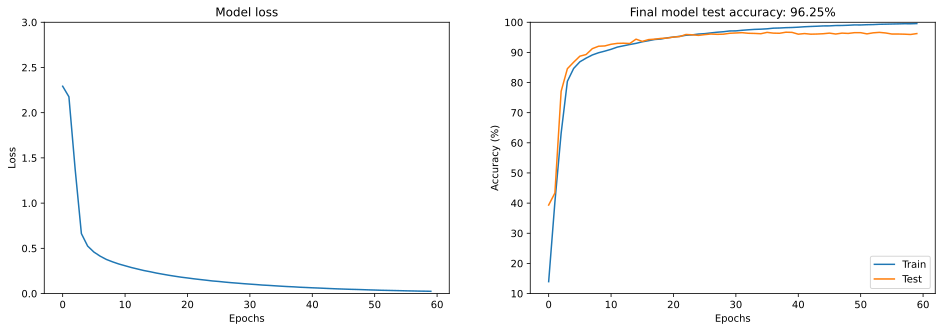

In [12]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()